<a href="https://colab.research.google.com/github/AnnaGass/DSA-SleepHealthData/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title # Select the subject to be used { display-mode: "both" }
variable_name = ""

subject = '006'

# Install python libraries and load packages

In [2]:
# @title Install needed libraries { display-mode: "both" }
!pip install pyedflib
!pip install pandas

!pip install pandas scikit-learn

In [3]:
# @title Import libraries { display-mode: "both" }
import subprocess
import pyedflib
import csv
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import timedelta
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

# Import data

In [4]:
# @title Define constants
base_url = "https://physionet.org/files/ucddb/1.0.0/ucddb" + subject
orig_data = "/content/physionet.org/files/ucddb/1.0.0/ucddb" + subject
output_directory = "data_preparation/subject" + subject + "/"

In [5]:
# @title Import the data from physionet { display-mode: "both" }

base_command = "wget -r -N -c -np "

rec_path = base_url + ".rec"
sleep_annotation_path = base_url + "_stage.txt"
apnea_annotation_path = base_url + "_respevt.txt"

command = base_command + rec_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

command = base_command + sleep_annotation_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

command = base_command + apnea_annotation_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Prepare the data

In [6]:
# @title Create output directory for subject

# Create results folder if not exists
if not os.path.exists("results"):
    os.makedirs("results")

if not os.path.exists(output_directory):
  os.makedirs(output_directory)

In [7]:
# @title Extract signals from .rec file

# open the input file
rec_file_path = orig_data + ".rec"
f = pyedflib.EdfReader(rec_file_path)

# Specify the output file name
signals_csv = output_directory + "01_orig_signals.csv"

# Specify which signals to use
spo2_index = 6      # taken from the headers
pulse_index = 13    # taken from the headers

# Initialize an empty list to store your values
data = []

# file properties
start_time = f.getStartdatetime()
file_duration = f.getFileDuration()
signal_labels = f.getSignalLabels()

# SpO2 information
spo2_header = f.getSignalHeader(spo2_index)
spo2_signals = f.readSignal(spo2_index)

# Pulse information
pulse_header = f.getSignalHeader(pulse_index)
pulse_signals = f.readSignal(pulse_index)

# Calculate frequency
time_between_meassurements = file_duration / len(pulse_signals)

# Iterate and add the increment to the datetime on each iteration
for i in range(len(pulse_signals)):
    date_str = start_time.strftime('%Y-%m-%d')
    if start_time.microsecond != 0:
       time_str = start_time.strftime('%H:%M:%S.%f')
    else:
       time_str = start_time.strftime('%H:%M:%S')
    data.append([date_str, time_str, spo2_signals[i], pulse_signals[i]])
    start_time += timedelta(seconds=time_between_meassurements)

# Write the data to a CSV file
with open(signals_csv, 'w', newline='') as file:
    # Create a CSV writer object for the output file
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Date', 'Time', 'SpO2', 'Pulse'])
    writer.writerows(data)
f.close()

In [8]:
# @title Extract data from respevt.txt file

# Specify the input file name
annotations_path = orig_data + "_respevt.txt"

# Specify the output file name
output_csv_annotations = output_directory + "02_apnea_annotations.csv"

# Open the input file
with open(annotations_path, 'r') as infile:
    # Skip the first two lines (header)
    next(infile)
    next(infile)
    next(infile)

    # Open a CSV file for writing with more parameters
    with open(output_csv_annotations, 'w', newline='') as outfile_extra:
        # Create a CSV writer object for the output file
        writer = csv.writer(outfile_extra)

        # Write the header
        writer.writerow(['Time', 'Apnea'])

        # Process each line in the input file
        for line in infile:
            # Split the line into columns
            columns = line.split()

            # Check if the line has enough columns
            if len(columns) >= 5:

                # Extract the required columns
                time_str = columns[0]
                event_type = columns[1]
                duration_str = columns[2] if columns[2] != "EVENT" else columns[4]


                # Parse duration into seconds
                duration_seconds = int(duration_str)

                # Parse time string into datetime object
                time = datetime.strptime(time_str, '%H:%M:%S')

                # Iterate over the duration and add one second to the time in each iteration
                for _ in range(duration_seconds):

                    # Write the time, event type, and duration to the CSV file
                    writer.writerow([time.strftime('%H:%M:%S'), event_type])

                    # Add one second to the time
                    time += timedelta(seconds=1)

In [9]:
# @title Extract data from stage.txt file

# Specify the input file name
input_stage = orig_data + "_stage.txt"

# Specify the output file name
output_csv_stage = output_directory + "03_sleep_stages.csv"

# Open the input text file in read mode and the output CSV file in write mode
with open(input_stage, 'r') as infile:
  with open(output_csv_stage, 'w', newline='') as outfile_stage:
        # Create a CSV writer object for the output file
        writer = csv.writer(outfile_stage)

        # Write the header
        writer.writerow(['Sleep Stage'])

        # Process each line in the input file
        for line in infile:
            # Remove leading and trailing whitespace and split the line into columns
            line = line.strip()
            # Write the sleep stage value to the CSV file
            writer.writerow([line])

In [10]:
# @title Sort the data in the orig_signals.csv and merge it with sleep_stages.csv and apnoe_annotations.csv

merged_csv = output_directory + "04_merged.csv"

# Load data from the _signals.csv file
df_signals = pd.read_csv(signals_csv)

# Sort the data to keep only the rows where the time values have seconds only
df_signals = df_signals[df_signals['Time'].str.contains(r'^\d{2}:\d{2}:\d{2}$')]
df_signals_withoutmiliseconds = df_signals.copy()

# Load data from the apnea_annotations.csv file and merge it with the filtered signal data using the 'Time' column
df_apnea_anno = pd.read_csv(output_csv_annotations)
df_merged_anno = pd.merge(df_signals_withoutmiliseconds, df_apnea_anno, on='Time', how='left')

# =================================================================================================

# Load data from the sleep_stages.csv file
df_apnea_stage = pd.read_csv(output_csv_stage, dtype=int)

# Initialize an empty list to store combined data
combined_data = []

for i in range(len(df_signals_withoutmiliseconds)):
    # Calculate the index for the data from df_apnea_stage based on the 30-second intervals
    apnea_index = i // 30

    # Ensure the index does not exceed the number of rows in df_apnea_stage
    apnea_index = min(apnea_index, len(df_apnea_stage) - 1)

    # Append the corresponding entry from df_apnea_stage to the combined data list
    combined_data.append(df_apnea_stage.iloc[apnea_index].tolist())

# Convert the combined data list into a DataFrame
df_combined_stage = pd.DataFrame(combined_data, columns=df_apnea_stage.columns)

# Merge the combined data with the merged signal and annotation data
df_merged_stage = pd.concat([df_merged_anno, df_combined_stage], axis=1)

# Save the merged data to a new CSV file
df_merged_stage.to_csv(merged_csv, index=False)

In [11]:
# @title Remove all datasets where SpO2 < 80 or 40 < Pulse < 180 (Meassurement error)

# Load the CSV file into a DataFrame
df = pd.read_csv(merged_csv)

merged_clean_csv = output_directory + "05_merged_clean.csv"

spo2_threshold = 80
pulse_lower_threshold = 40
pulse_upper_threshold = 180

df = df[df['SpO2'] >= spo2_threshold]
df = df[df['Pulse'] >= pulse_lower_threshold]
df = df[df['Pulse'] <= pulse_upper_threshold]

# Save the filtered DataFrame to a new CSV file
df.to_csv(merged_clean_csv, index=False)

In [12]:
# @title Categorize SpO2 and Pulse
# @markdown 0-70 = Invalid, 70-80 = Severe Hypoxia, 80-90 = Critical, 90-94 = Decreased, 94-100 = Normal

# Load the CSV file into a DataFrame
df = pd.read_csv(merged_clean_csv)

# Define the name of the output file
spo2_categorized_csv = output_directory + "06_spo2_categorized.csv"

# Define the categorization function
def categorize_spo2(value):
    if value >= 0 and value < 70:
        return 'Invalid'
    elif value >= 70 and value < 80:
        return 'Severe Hypoxia'
    elif value >= 80 and value < 90:
        return 'Critical'
    elif value >= 90 and value < 94:
        return 'Decreased'
    elif value >= 94 and value <= 100:
        return 'Normal'
    else:
        return 'Out of Range'  # In case the value is out of the expected range

# Apply the categorization function to the relevant column
df['SpO2 Category'] = df['SpO2'].apply(categorize_spo2)

# Save the DataFrame to a new CSV file (optional)
df.to_csv(spo2_categorized_csv, index=False)

In [13]:
# @title Categorize Pulse
# @markdown Bin size = (max_value - min_value) / number_of_bins
number_of_bins = 7 # @param {type:"integer"}

# Load the CSV file into a DataFrame
df = pd.read_csv(spo2_categorized_csv)

# Define the name of the output file
pulse_categorized_csv = output_directory + "07_pulse_categorized.csv"

# Find out the smallest and biggest values for pulse
min_value = df['Pulse'].min()
max_value = df['Pulse'].max()

# Calculate the bin size
bin_size = (max_value - min_value) / number_of_bins

# Create a list of bin edges
bin_edges = [min_value + i * bin_size for i in range(number_of_bins + 1)]

# Function to assign value to correct bin
def categorize_pulse(value):
    for i in range(number_of_bins):
        if bin_edges[i] <= value < bin_edges[i + 1]:
            return f'[{bin_edges[i]:.2f} - {bin_edges[i + 1]:.2f}]'
    return f'[{bin_edges[-2]:.2f} - {bin_edges[-1]:.2f}]'  # For the last bin

# Apply the categorization function to the relevant column
df['Pulse Range'] = df['Pulse'].apply(categorize_pulse)

# Save the filtered and categorized DataFrame to a new CSV file
df.to_csv(pulse_categorized_csv, index=False)


In [14]:
# @title Set the correct text for sleep phase

# Load the CSV file into a DataFrame
df = pd.read_csv(pulse_categorized_csv)

# Define the name of the output file
sleep_stage_text_csv = output_directory + "08_sleep_stage_text.csv"

# Define the mapping for the "Sleep Stage" column
sleep_stage_mapping = {
    0: 'Wake',
    1: 'REM',
    2: 'Stage 1',
    3: 'Stage 2',
    4: 'Stage 3',
    5: 'Stage 4',
    6: 'Artifact',
    7: 'Indeterminate'
}

# Apply the mapping to the "Sleep Stage" column
df['Sleep Stage'] = df['Sleep Stage'].map(sleep_stage_mapping)

# Save the updated DataFrame to a new CSV file
df.to_csv(sleep_stage_text_csv, index=False)

In [15]:
# @title Simplify target class

# Load the CSV file into a DataFrame
df = pd.read_csv(sleep_stage_text_csv)

# Define the name of the output file
final_csv = output_directory + "09_final.csv"

def normalize_apnea_column(value):
    if str(value).startswith('AP'):
        return 'Apnea'
    elif str(value).startswith('HYP'):
        return 'Hypoapnea'
    else:
        return 'Nothing'

# Apply the normalization function to the target class
df['Apnea'] = df['Apnea'].apply(normalize_apnea_column)

# Save the filtered, categorized, and normalized DataFrame to a new CSV file
df.to_csv(final_csv, index=False)

# Data Analysis

Accuracy: 0.8892887383573242
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       156
           1       0.50      0.05      0.08       367
           2       0.89      1.00      0.94      4201

    accuracy                           0.89      4724
   macro avg       0.46      0.35      0.34      4724
weighted avg       0.83      0.89      0.84      4724



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


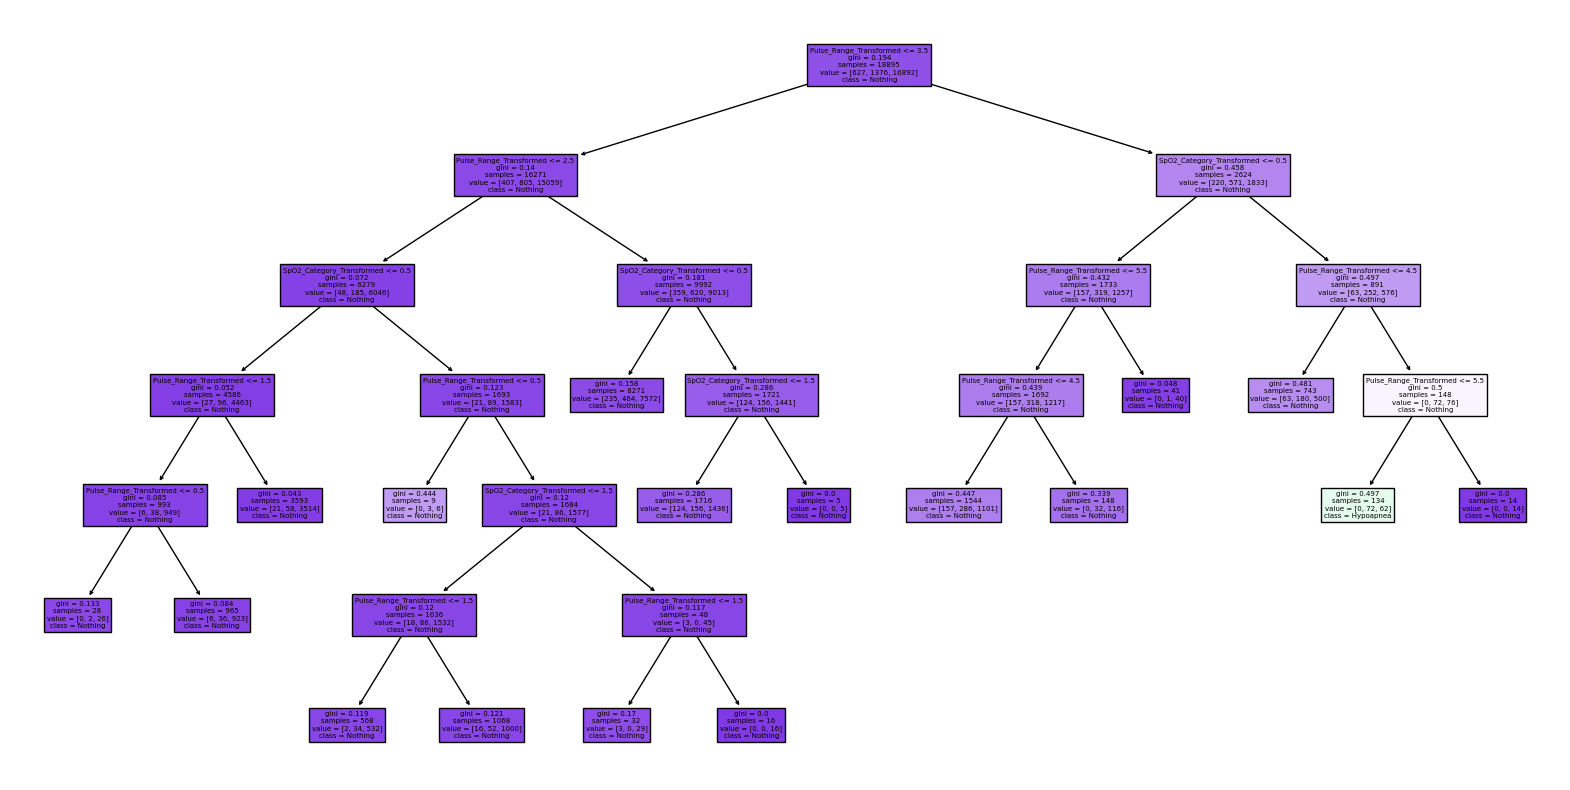

In [16]:
# Load the CSV file
data = pd.read_csv(final_csv)

# Initialize the LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each categorical feature
df['SpO2_Category_Transformed'] = le.fit_transform(df['SpO2 Category'])
df['Pulse_Range_Transformed'] = le.fit_transform(df['Pulse Range'])
df['Apnea_Transformed'] = le.fit_transform(df['Apnea'])

# Split the data into features and target
X = df[['SpO2_Category_Transformed', 'Pulse_Range_Transformed']]
y = df['Apnea_Transformed']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print classification report
print(classification_report(y_test, y_pred))

# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=X.columns, class_names=le.classes_, filled=True)
plt.show()

# Visualizations

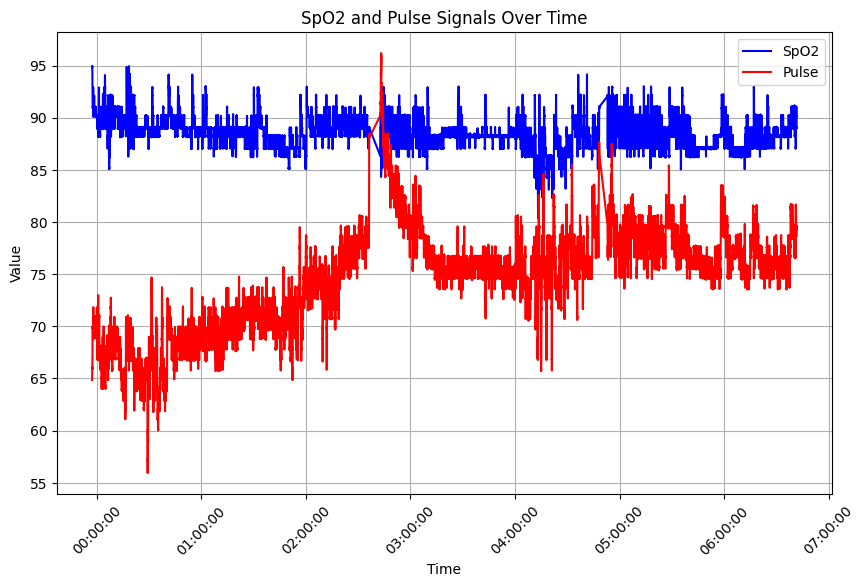

In [17]:
# @title Plot the signals from orig_signals.csv { display-mode: "both" }

# Load CSV data into a DataFrame assuming the order of columns is timestamp, spo2, and pulse
df = pd.read_csv(final_csv)

# Define the ouput for the diagramm
plot_png = output_directory + "signals_plot.png"

# Assuming the columns are in order: date, time, spo2, and pulse
date = df['Date']
time = df['Time']
spo2 = df['SpO2']
pulse = df['Pulse']

# Combine date and time into a single string column 'Timestamp'
df['Timestamp'] = df['Date'] + ' ' + df['Time']

# Parse each datetime string into a datetime object
datetime_objects = []
for dt_str in df['Timestamp']:
    try:
        # Try parsing with milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S.%f")
    except ValueError:
        # If milliseconds are not present, parse without milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S")
    datetime_objects.append(dt_obj)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(datetime_objects, df['SpO2'], label='SpO2', color='blue')
plt.plot(datetime_objects, df['Pulse'], label='Pulse', color='red')

plt.title('SpO2 and Pulse Signals Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
#plt.ylim(60, 110)
plt.grid(True)

# Set the format of the x-axis ticks to display only the time part
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Save the plot to a file
plt.savefig(plot_png)

# Show the plot
plt.show()
